In [ ]:
import torch
import torch.nn as nn
from torch.nn.functional import relu, log_softmax
import torch.optim as optim
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
import string 
from sklearn import feature_extraction
import nltk
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

nltk.download('stopwords')
nltk.download('punkt')

torch.manual_seed(1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Download and import the dataset from here https://drive.google.com/file/d/1o7TcsfaUk4ULpIAuQNCHVqLLR7CwXtpp/view?usp=sharing
with open('harry_potter.txt', 'r') as file:
    data = file.read().replace('\n', ' ')

df = pd.DataFrame({'text': [data]})
display(df)

,text
0,"THE BOY WHO LIVED Mr. and Mrs. Dursley, of nu..."


In [ ]:
cv = feature_extraction.text.CountVectorizer()

def simplify_text(df):
    def preprocess_text(text):
        if not hasattr(preprocess_text, "punctuation_table"):
            preprocess_text.punctuation_table=str.maketrans('','',string.punctuation)

        if not hasattr(preprocess_text, "stop_words"):
            preprocess_text.stop_words = set(stopwords.words("english"))
        
        text = text.translate(preprocess_text.punctuation_table)
        word_tokens = word_tokenize(text)
        
        filtered_text = []
        for w in word_tokens:
            if w not in preprocess_text.stop_words:
                filtered_text.append(w.lower())
                
        return TreebankWordDetokenizer().detokenize(filtered_text)

    processed_text = [preprocess_text(text) for text in df["text"]]
    df['processed'] = processed_text

    return df

def bag_of_words(df):
    context = []
    label = []

    def expand_text(text):
        words = text.split()

        if len(words) < 5:
            return None

        for idx in range(2, len(words) - 2):
            context.append(' '.join([words[idx-2], words[idx-1], words[idx+1], words[idx+2]]))
            label.append(words[idx])

    for text in df['processed']:
        expand_text(text)
    
    bag_of_words_df = pd.DataFrame({
        'context': context,
        'label': label,
    })

    return bag_of_words_df

def vectorize(df):
    # Learn vocabulary
    cv.fit(df['context'] + ' ' + df['label'])

    context = torch.tensor(cv.transform(df['context']).toarray()).to(torch.float)
    label = torch.tensor(cv.transform(df['label']).toarray()).to(torch.float)
    
    dataset = TensorDataset(context, label)
    return dataset

In [ ]:
df = simplify_text(df)
display(df)

,text,processed
0,"THE BOY WHO LIVED Mr. and Mrs. Dursley, of nu...",the boy who lived mr mrs dursley number four p...


In [ ]:
bag_of_words_df = bag_of_words(df)
display(bag_of_words_df)

,context,label
0,the boy lived mr,who
1,boy who mr mrs,lived
2,who lived mrs dursley,mr
3,lived mr dursley number,mrs
4,mr mrs number four,dursley
...,...,...
53835,home i going lot,’
53836,i ’ lot fun,going
53837,’ going fun dudley,lot
53838,going lot dudley summer,fun


In [ ]:
dataset = vectorize(bag_of_words_df)

In [ ]:
EMBEDDING_DIM = 2
VOCAB_SIZE = len(dataset[0][0])

class Model(nn.Module):
    def __init__(self, embedding_dim, vocab_size):
        super().__init__()

        self.linear1 = nn.Linear(vocab_size, embedding_dim)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(embedding_dim, vocab_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input):
        out = input

        out = self.linear1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        # Use softmax to get value from 0-1. Expected that only one dimension is close to 1 as label is a single word
        out = self.softmax(out)
        
        return out

In [ ]:
model = Model(EMBEDDING_DIM, VOCAB_SIZE)

In [ ]:
dataloader = DataLoader(dataset, batch_size=1)

In [ ]:
print(model)

Model(
  (linear1): Linear(in_features=5812, out_features=2, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=2, out_features=5812, bias=True)
  (softmax): Softmax(dim=1)
)


epoch 0, loss -9.511959069641307e-05


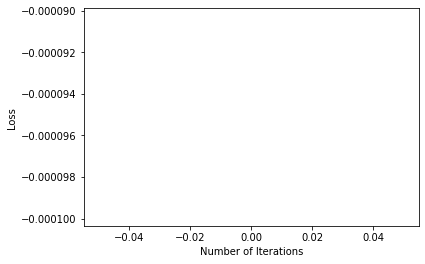

In [ ]:
log_loss = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

iteration_number = 1
loss_list = []

for iteration in range(iteration_number):
    for batch_idx, (features, label) in enumerate(dataloader):
        optimizer.zero_grad()

        # Shape of features is batch_size * feature_vector
        # Shape of label is batch_size * label_vector
        # cross entropy loss expects output and label to be one value rather than a one hot vector
        # so we use argmax to get the dimension of the '1' label. 
        output = model(features)
        
        label = torch.argmax(label, dim=1)
        loss = log_loss(output, label)
        
        loss.backward()
        optimizer.step()

    loss_list.append(loss.data)
    print('epoch {}, loss {}'.format(iteration, loss.data))

plt.plot(range(iteration_number),loss_list)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

In [ ]:
activation = {}
def get_activation(name):
    activation[name] = []
    def hook(model, input, output):
        activation[name].append(output.detach().numpy())
    return hook

model.linear1.register_forward_hook(get_activation('word_embedding'))

In [ ]:
example_words = pd.DataFrame({
    'input': ['king', 'queen', 'husband', 'wife', 'man', 'woman']
})['input']
example_words_ohe = torch.tensor(cv.transform(example_words).toarray()).to(torch.float)
example_dataset = TensorDataset(example_words_ohe)
example_dataloader = DataLoader(example_dataset, batch_size=1)

for batch_idx, (example, ) in enumerate(example_dataloader):
    output = model(example)

In [ ]:
embeddings = activation['word_embedding']

fig = px.scatter(
    np.array(embeddings).reshape(len(embeddings), 2), x=0, y=1,
    text=example_words,
)
fig.show()

In [ ]:
# Reset stored activations
get_activation('word_embedding')

example_words = bag_of_words_df['label'].unique()
example_words_ohe = torch.tensor(cv.transform(example_words).toarray()).to(torch.float)
example_dataset = TensorDataset(example_words_ohe)
example_dataloader = DataLoader(example_dataset, batch_size=1)

for batch_idx, (example, ) in enumerate(example_dataloader):
    output = model(example)

In [ ]:
# Show the embeddings of the first 500 words
embeddings = activation['word_embedding'][:500]

fig = px.scatter(
    np.array(embeddings).reshape(len(embeddings), 2), x=0, y=1,
    text=example_words[:500],
)
fig.update_traces(marker_size=8)
fig.show()

In [ ]:
def get_nearest(word, k):
    word_embedding = None

    embeddings = activation['word_embedding']
    embeddings = np.array(embeddings).reshape(len(embeddings), 2)

    # Find the embedding of the word
    for i in range(len(example_words)):
        if example_words[i] == word:
            word_embedding = embeddings[i]

    if word_embedding is None:
        print("Word embedding not found")
        return

    # Compute Euclidean distances
    distances = cdist(embeddings, np.array([word_embedding]), metric='euclidean')
    distances = distances.reshape(len(distances))

    # k+1 since we know the most similar word will be the passed in word which we will skip
    closest_idx = np.argsort(distances)[:k+1]

    result = []
    for i, idx in enumerate(closest_idx):
        if i == 0:
            # The most similar word will be the passed in word, so we should ignore this
            continue

        result.append(example_words[idx])

    return result

nearest = get_nearest('slytherin', 1)
print(nearest)

['pure']
